In [258]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from PIL import Image
import mlflow
import mlflow.sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import optuna

import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

from mlflow import MlflowClient
import requests

## Table of content
- 1. [COVID-19](#1-covid-19-dataset-)
- 2. [23_end](#pipeline)

<a id=COVID-19 Dataset></a>

## 1. COVID-19 Dataset 



#### COVID-19 patient's symptoms, status, and medical history.

#### About Dataset

This dataset is taken from Kaggle platform (https://www.kaggle.com/datasets/meirnizri/covid19-dataset)  


##### Context  

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

##### content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [200]:
data = pd.read_csv('data/Covid_data.csv')
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [201]:
missing_values_count = data.apply(lambda col: col.isin([97, 99]).sum())
missing_values_count

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        221
PREGNANT                523511
DIABETES                     0
COPD                         0
ASTHMA                       0
INMSUPR                      0
HIPERTENSION                 0
OTHER_DISEASE                0
CARDIOVASCULAR               0
OBESITY                      0
RENAL_CHRONIC                0
TOBACCO                      0
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

In [202]:
data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

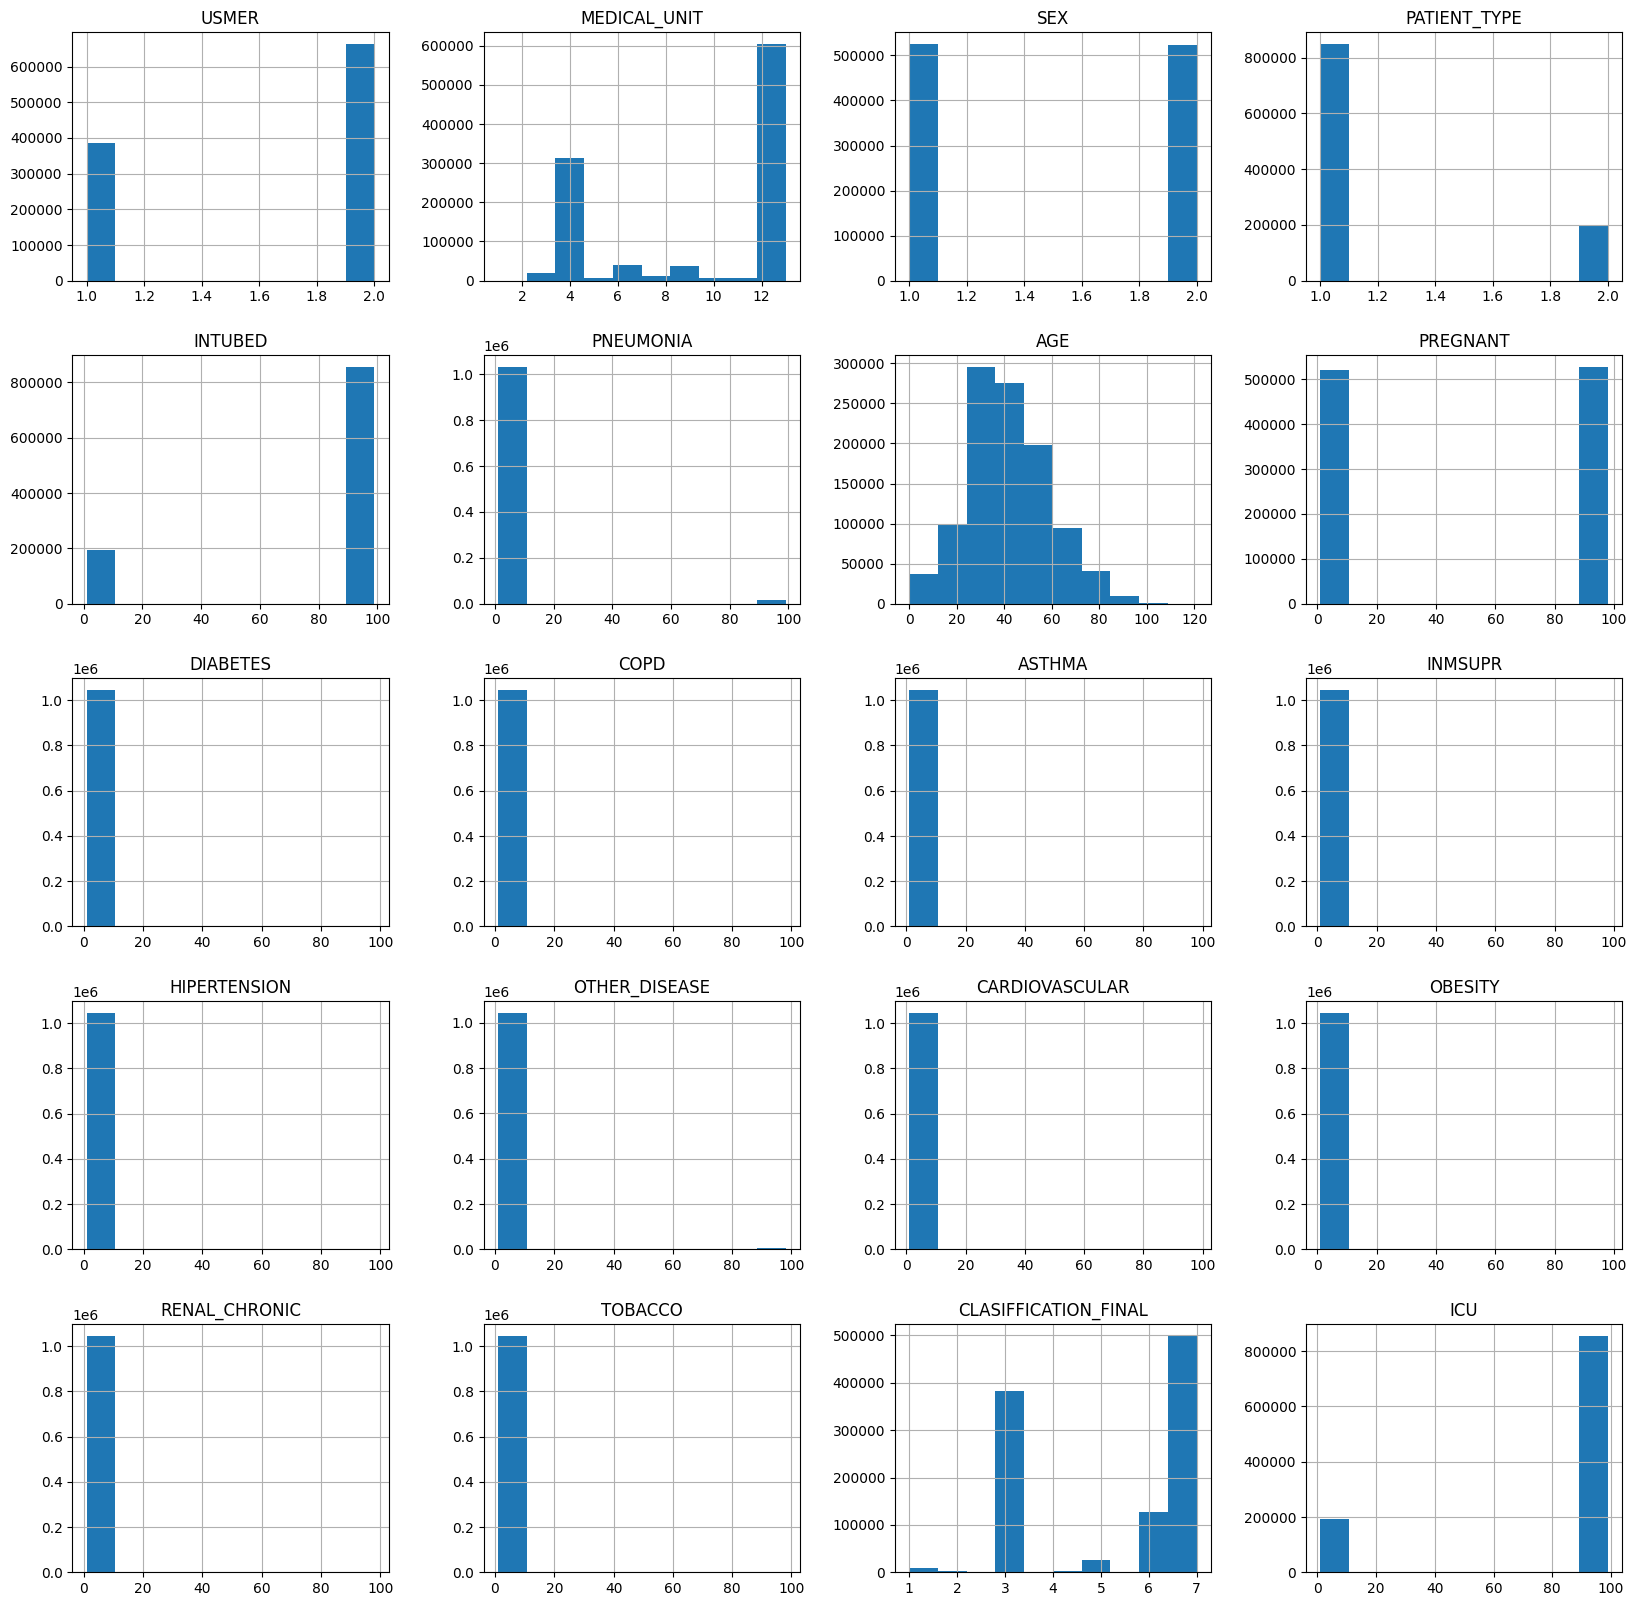

In [203]:
data.hist(figsize=(20, 20));

## 2. Pipeline

In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [205]:
# let's make this classification task

data.loc[~data['DATE_DIED'].isin(['9999-99-99']), 'DATE_DIED'] = 1 #checks if the  column is not in the list ['9999-99-99'].
data.loc[data['DATE_DIED'] == '9999-99-99', 'DATE_DIED'] = 0


In [206]:
X = data.drop('DATE_DIED',axis=1)
y = data['DATE_DIED']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.7, random_state=13)


In [208]:
X_train

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
1016261,1,12,1,1,97,2,37,2,2,2,2,2,2,2,2,2,2,2,7,97
44034,1,4,1,2,99,2,33,2,1,2,2,2,1,2,2,2,2,2,3,99
348060,1,6,2,2,2,1,55,97,1,2,2,2,1,2,2,2,1,1,3,2
846623,2,12,1,1,97,2,4,2,2,2,2,2,2,2,2,2,2,2,7,97
235661,1,4,1,1,97,2,36,2,2,2,2,2,2,2,2,2,2,2,7,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42933,2,4,1,2,1,1,35,2,2,2,2,2,1,1,2,2,1,2,3,2
853104,1,12,1,1,97,2,38,2,2,2,2,2,1,2,2,2,2,2,7,97
912926,2,12,1,1,97,2,28,2,2,2,2,2,2,2,2,2,2,2,7,97
68216,2,4,1,1,97,2,34,2,2,2,2,2,2,2,2,1,2,2,3,97


### Pipeline

In [209]:
numerical_features = ['AGE']

categorical_features = [i for i in X_train.columns if i not in numerical_features]

# numeric data pipeline
pipe_num = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # not necessary because we have already clean data 
    ('power_tr', PowerTransformer()),
    ('scaler', StandardScaler()) ])

# cat data pipeline
pipe_cat = Pipeline([
    # ('imputer', SimpleImputer(strategy='constant',fill_value='unknown')), # not necessary because we have already clean data 
    ('encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])

# column transformer
ct = ColumnTransformer([
    ('pipe_num', pipe_num, numerical_features),
    ('pipe_cat', pipe_cat, categorical_features) ])

## 3. Model training

### 3.1 XGBoost model
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [210]:
#full pipeline with XGBoost
pipe = Pipeline([
    ('column_transformer', ct),
    ('model', xgb.XGBClassifier()),  # It denotes the fraction of observations to be randomly samples for each tree. 
])


In [211]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
client = MlflowClient()
local_dir = ('C:/Users/Peter/DataspellProjects/pollock')


In [252]:
# optimize hyperparameters with Optuna
def objective(trial):

    # params for optimization
    params = {
        'model__eta': trial.suggest_float('model__eta', 0.01, 0.2),
        'model__gamma': trial.suggest_float('model__gamma', 0.01, 5),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 10),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 1, 10),
        'model__max_delta_step': trial.suggest_float('model__max_delta_step', 0.001, 10),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.5, 1),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1),
        'model__colsample_bynode': trial.suggest_float('model__colsample_bynode', 0.5, 1),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 1e-5, 1e2),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 1e-5, 1e2),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
        'model__max_leaves': trial.suggest_int('model__max_leaves', 1, 100),
    }

    pipe.set_params(**params)

    # model fitting
    cross_val_f1 = cross_val_score(pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification


mlflow.set_experiment("MLflow_hype_optuna_XGB")

with mlflow.start_run(run_name='xgb_optuna_run'):
    study = optuna.create_study(direction='maximize')  # Maximize F1 score
    study.optimize(objective, n_trials=10)

    best_trial = study.best_trial
    best_params = best_trial.params

    # Log parameters
    mlflow.log_params(best_params)

    # Set the best parameters to your model
    pipe.set_params(**best_params)

    # Train the model with the best parameters on the entire training set
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)


# Metrics
    accuracy = accuracy_score(list(y_test), y_pred)
    recall = recall_score(list(y_test), y_pred)
    f1 = f1_score(list(y_test), y_pred)

    mlflow.sklearn.log_model(pipe, 'xgb_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr, tpr, thresholds = roc_curve(list(y_test), y_pred)
    roc_auc = roc_auc_score(list(y_test), y_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_plot_path = "roc_auc_plot.png"
    plt.savefig(roc_auc_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")


[I 2024-01-10 15:14:02,072] A new study created in memory with name: no-name-eb6228f6-59c5-4e90-bee3-f7267fe63b76
[I 2024-01-10 15:15:19,537] Trial 0 finished with value: 0.5871850806760845 and parameters: {'model__eta': 0.15909617205129029, 'model__gamma': 1.3573802954898002, 'model__max_depth': 5, 'model__min_child_weight': 4.802223788097713, 'model__max_delta_step': 4.709787186446783, 'model__subsample': 0.1442827438873253, 'model__colsample_bytree': 0.5954907682759512, 'model__colsample_bylevel': 0.5593015886730033, 'model__colsample_bynode': 0.6917372177687835, 'model__reg_lambda': 91.84139549646784, 'model__reg_alpha': 77.64591933721037, 'model__scale_pos_weight': 7.796108088676334, 'model__max_leaves': 83}. Best is trial 0 with value: 0.5871850806760845.
[I 2024-01-10 15:16:46,347] Trial 1 finished with value: 0.6481518703267013 and parameters: {'model__eta': 0.080935761227931, 'model__gamma': 2.4576862200386795, 'model__max_depth': 3, 'model__min_child_weight': 4.47367329704608

In [256]:
logged_model_xgb = 'runs:/38d9fc155e7f4dc3b5e1cdce89a95577/xgb_model_optuna'

# Load model as a PyFuncModel.
loaded_model_xgb = mlflow.pyfunc.load_model(logged_model_xgb)

In [257]:
joblib.dump(loaded_model_xgb,'xgb_optuna_model.joblib')

['xgb_optuna_model.joblib']

### 3.1 CatBoost model
Catboost is a boosted decision tree machine learning algorithm developed by Yandex. It works in the same way as other gradient boosted algorithms such as XGBoost but provides support out of the box for categorical variables, has a higher level of accuracy without tuning parameters and also offers GPU support to speed up training.


In [259]:
# Full pipeline with CatBoost
cat_pipe = Pipeline([
    ('column_transformer', ct),
    ('model', CatBoostClassifier()),  # Use CatBoostClassifier
])

In [260]:
# Optimize hyperparameters with Optuna
def objective(trial):

    # Parameters for optimization
    cat_params = {
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 0.2),
        'model__depth': trial.suggest_int('model__depth', 3, 10),
        'model__l2_leaf_reg': trial.suggest_float('model__l2_leaf_reg', 1, 10),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
    }

    cat_pipe.set_params(**cat_params)

    # Model fitting
    cross_val_f1 = cross_val_score(cat_pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification

mlflow.set_experiment("MLflow_hype_optuna_CatBoost")

with mlflow.start_run(run_name='catboost_optuna_run'):
    cat_study = optuna.create_study(direction='maximize')  # Maximize F1 score
    cat_study.optimize(objective, n_trials=1)

    best_cat_trial = cat_study.best_trial
    best_cat_params = best_cat_trial.params

    # Log parameters
    mlflow.log_params(best_cat_params)

    # Set the best parameters to your CatBoost model
    cat_pipe.set_params(**best_cat_params)

    # Train the model with the best parameters on the entire training set
    cat_pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_cat_pred = cat_pipe.predict(X_test)

    # Metrics
    accuracy_cat = accuracy_score(list(y_test), y_cat_pred)
    recall_cat = recall_score(list(y_test), y_cat_pred)
    f1_cat = f1_score(list(y_test), y_cat_pred)

    mlflow.sklearn.log_model(cat_pipe, 'catboost_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_cat,
        'recall': recall_cat,
        'f1_score': f1_cat,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr_cat, tpr_cat, thresholds_cat = roc_curve(list(y_test), y_cat_pred)
    roc_auc_cat = roc_auc_score(list(y_test), y_cat_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cat))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_cat_plot_path = "roc_auc_cat_plot.png"
    plt.savefig(roc_auc_cat_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_cat_plot_path, "roc_auc_cat_plot")

2024/01/10 17:11:48 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_hype_optuna_CatBoost' does not exist. Creating a new experiment.
[I 2024-01-10 17:11:48,891] A new study created in memory with name: no-name-b8a307cd-f0af-47ca-95fb-b86bf11f9b49


0:	learn: 0.3948860	total: 175ms	remaining: 2m 54s
1:	learn: 0.2638719	total: 217ms	remaining: 1m 48s
2:	learn: 0.2205168	total: 254ms	remaining: 1m 24s
3:	learn: 0.1783920	total: 293ms	remaining: 1m 12s
4:	learn: 0.1690652	total: 335ms	remaining: 1m 6s
5:	learn: 0.1585038	total: 371ms	remaining: 1m 1s
6:	learn: 0.1535079	total: 412ms	remaining: 58.5s
7:	learn: 0.1479458	total: 464ms	remaining: 57.6s
8:	learn: 0.1428989	total: 512ms	remaining: 56.4s
9:	learn: 0.1392266	total: 552ms	remaining: 54.6s
10:	learn: 0.1379436	total: 600ms	remaining: 53.9s
11:	learn: 0.1367218	total: 648ms	remaining: 53.4s
12:	learn: 0.1359995	total: 703ms	remaining: 53.4s
13:	learn: 0.1352063	total: 825ms	remaining: 58.1s
14:	learn: 0.1334139	total: 889ms	remaining: 58.4s
15:	learn: 0.1328628	total: 937ms	remaining: 57.6s
16:	learn: 0.1324722	total: 979ms	remaining: 56.6s
17:	learn: 0.1320194	total: 1.02s	remaining: 55.9s
18:	learn: 0.1312836	total: 1.07s	remaining: 55.2s
19:	learn: 0.1309780	total: 1.12s	rem

[I 2024-01-10 17:17:36,133] Trial 0 finished with value: 0.6420969289929509 and parameters: {'model__learning_rate': 0.18788202673890703, 'model__depth': 3, 'model__l2_leaf_reg': 8.682321727802982, 'model__subsample': 0.34193827951994016, 'model__colsample_bylevel': 0.8761010871418629, 'model__scale_pos_weight': 1.2437331117720452}. Best is trial 0 with value: 0.6420969289929509.


0:	learn: 0.3947881	total: 46.7ms	remaining: 46.7s
1:	learn: 0.2639605	total: 95.3ms	remaining: 47.5s
2:	learn: 0.2221390	total: 143ms	remaining: 47.6s
3:	learn: 0.1882782	total: 190ms	remaining: 47.3s
4:	learn: 0.1759860	total: 253ms	remaining: 50.4s
5:	learn: 0.1595997	total: 305ms	remaining: 50.6s
6:	learn: 0.1527018	total: 358ms	remaining: 50.8s
7:	learn: 0.1458507	total: 407ms	remaining: 50.4s
8:	learn: 0.1435741	total: 457ms	remaining: 50.3s
9:	learn: 0.1418938	total: 507ms	remaining: 50.2s
10:	learn: 0.1383746	total: 559ms	remaining: 50.2s
11:	learn: 0.1374269	total: 608ms	remaining: 50.1s
12:	learn: 0.1365913	total: 670ms	remaining: 50.8s
13:	learn: 0.1357108	total: 724ms	remaining: 51s
14:	learn: 0.1338569	total: 771ms	remaining: 50.6s
15:	learn: 0.1333280	total: 818ms	remaining: 50.3s
16:	learn: 0.1328619	total: 875ms	remaining: 50.6s
17:	learn: 0.1320750	total: 925ms	remaining: 50.5s
18:	learn: 0.1317799	total: 976ms	remaining: 50.4s
19:	learn: 0.1314054	total: 1.02s	remaini

C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\ProgramData\anaconda3\envs\kanagawa\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [260]:
logged_model_catb = 'runs:/99549db16c9b4884b06402a72fc1809f/catboost_model_optuna'

# Load model as a PyFuncModel.
loaded_model_catb = mlflow.pyfunc.load_model(logged_model_catb)

In [ ]:
joblib.dump(loaded_model_xgb,'catb_optuna_model.joblib')